In [1]:
import os
import itertools
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from time import time

import scipy
import librosa
import sed_eval

import matplotlib.pyplot as plt
import matplotlib.cm

import csv
import dcase_util

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def FeatureExtraction(FilePath,Parameters):
    sr = Parameters['sampling_rate']
    win_size =  Parameters['win_size']
    hop_size = Parameters['hop_size']

    audio_data,audio_sr = librosa.load(FilePath,sr, mono = True)

    #Other Features might be used========================================================
    #audio_mag = np.abs(librosa.stft(audio_data, n_fft=win_size, hop_length=hop_size)) 
    #Short Time Energy
    #ste = ShortTimeEnergy(signal=audio_data,win_size=win_size,hop_size=hop_size)
        #ZCR
    #zcr = librosa.feature.zero_crossing_rate(y=audio_data,frame_length=win_size,hop_length=hop_size)
        #Spectral Centroid
    #cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr,n_fft=win_size, hop_length=hop_size)
        #Spectral Entropy
    #entropy = Spectral_Entropy(y_Mag=audio_mag,sr=sr,n_short_blocks=10)
        #MFCCs and MFCCs with PCEN scaling
    #mfccs, pcens = PCEN_MFCC(y=audio_data,sr=sr,parameters=Parameters)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=20, dct_type=2, norm='ortho')
    #pnccs = PNCC(y=audio_data, sr=sr, parameters = Parameters)
    #Flatten all the feature matrix and concatenate them into a 1D vector
    #feature_vector = np.concatenate((mfccs,pnccs), axis = 0)
    return mfccs, audio_data, audio_sr
def PNCC(y,sr,parameters):
    '''
    Calculate the
        MFCCs : Mel-frequency cepstral coefficients (MFCCs)
        PCENs : using PCEN() to replace the log amplitude (dB) scaling on Mel spectra
    '''
    win_size = parameters['win_size']
    hop_size = parameters['hop_size']
    n_mels = parameters['num_mel_filters']
    n_dct = parameters['n_dct']
    fmin = parameters['min_freq']
    fmax = parameters['max_freq']
    mel_spectrogram = librosa.feature.melspectrogram(y=y, 
                                                    sr=sr,
                                                    n_fft=win_size, 
                                                    hop_length=hop_size, 
                                                    power=1, 
                                                    n_mels= n_mels,
                                                    fmin = fmin,
                                                    fmax = fmax)
    
    S_PNCC = librosa.pcen(mel_spectrogram * (2**31))
    
    return scipy.fftpack.dct(S_PNCC, axis=0, type=2, norm='ortho')[:n_dct]
def CreateLabelVector(Data,EventList,Parameters,LabelIndex=1):
    #Given audio data, event list, create its corresponding label vector with given index
    #list for saving number of frame labels. 
    hop_size = Parameters['hop_size']
    audio_sr = Parameters['sampling_rate']
    label_vector = np.zeros(int(np.ceil(len(Data)/hop_size)))                      
    for event in EventList:
        osnet_frame = np.ceil(event['onset'] * audio_sr/hop_size).astype(int)
        offset_frame = np.floor(event['offset'] * audio_sr/hop_size).astype(int)
        label_vector[osnet_frame:offset_frame] = LabelIndex
    return label_vector.astype(int)

def ComputeStateTransition(LabelVector):
        #Calculate the probability of status transition If data contains speech 
        ee_temp = 0 # num of event to event
        nn_temp = 0 # num of none to none
        en_temp = 0 # num of event to none
        ne_temp = 0 # num of none to event
        previous_e = 0 # num of frames with previous is event
        previous_n = 0 # num of frames with previous is none
        if sum(LabelVector) != 0:
            for frame_index in range(len(LabelVector)-1):
                if LabelVector[frame_index] == 0 and LabelVector[frame_index+1] > LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    ne_temp = ne_temp + 1
                elif LabelVector[frame_index] == 0 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    nn_temp = nn_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] < LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    en_temp = en_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    ee_temp = ee_temp + 1
            #compute the probability        
            p_ee = ee_temp/previous_e
            p_nn = nn_temp/previous_n
            p_en = en_temp/previous_e
            p_ne = ne_temp/previous_n
        return p_ee,p_nn,p_en,p_ne
    
def DatasetLoader(TrainPath,ValidatePath,TestPath):
    #train    
    train_data = np.load(TrainPath,allow_pickle=True)
    #validation    
    validate_data = np.load(ValidatePath,allow_pickle=True)
    #test    
    test_data = np.load(TestPath,allow_pickle=True)

    #Processing all the loaded dataset
    Train = {}
    #Train_Data = np.c_[train_data[:,0].tolist()]
    Train_Data = np.hstack(train_data[:,0].tolist()).transpose()
    Train_Label = np.hstack(train_data[:,1].tolist())
    print(Train_Data.shape)
    print(Train_Label.shape)
    #Train_Label = np.c_[train_data[:,1].tolist()]
    #Train_Data = np.hstack(Train_Data).transpose() #sklearn requires data in [n_samples,n_features]
    #Train_Label = np.hstack(Train_Label)
    Train['Data'] = Train_Data
    Train['Label'] = Train_Label

    Validation = {}
    Validate_Data = np.c_[validate_data[:,0].tolist()]
    Validate_Label = np.c_[validate_data[:,1].tolist()]
    Validate_Data = np.hstack(Validate_Data).transpose() #sklearn requires data in [n_samples,n_features]
    Validate_Label = np.hstack(Validate_Label)
    Validation['Data'] = Validate_Data
    Validation['Label'] = Validate_Label
    print(Validate_Data.shape)
    print(Validate_Label.shape)

    Test = {}
    Test_Data = np.c_[test_data[:,0].tolist()]
    Test_Label = np.c_[test_data[:,1].tolist()]
    Test_Data = np.hstack(Test_Data).transpose() #sklearn requires data in [n_samples,n_features]
    Test_Label = np.hstack(Test_Label)
    Test['Data'] = Test_Data
    Test['Label'] = Test_Label
    print(Test_Data.shape)
    print(Test_Label.shape)
    
    return Train,Validation,Test

def Write_Estimated_Annotation(Predicted_Label_Vector,AnAnnotation,AllAnnotations,Parameters):
    '''
    Predicted_Label_Vector:The predicted label vector generated by classifier
    AnAnnotation: a list for only storing a pair of onset&offset for single event
    AllAnnotaions: the list for storing multiple AnAnnotation-lists for one processing file.
    '''
    for i in range(len(Predicted_Label_Vector)-1):
                    #If next frame is different with current frame
                    if Predicted_Label_Vector[i] != Predicted_Label_Vector[i+1]:
                        #Next Frame:Speech; 
                        if Predicted_Label_Vector[i+1] - Predicted_Label_Vector[i] > 0:
                            #Append this Onset
                            AnAnnotation.append((i+1)*Parameters['hop_size']/Parameters['sampling_rate'])
                        #Next Frame:Non speech
                        elif Predicted_Label_Vector[i+1] - Predicted_Label_Vector[i] < 0:
                            #Append this Offset
                            AnAnnotation.append((i+1)*Parameters['hop_size']/Parameters['sampling_rate'])
                            AnAnnotation.append('speech')
                            if len(AnAnnotation) == 2:
                                AnAnnotation.insert(0,0)
                            AllAnnotations.append(AnAnnotation)
                            AnAnnotation = []
                    #Insert the ending frame and class label manually if the speech last til the end
                    if len(Predicted_Label_Vector) - 2 == i and Predicted_Label_Vector[i] == 1:
                        AnAnnotation.append(np.floor(len(Predicted_Label_Vector)*Parameters['hop_size']/Parameters['sampling_rate']))
                        AnAnnotation.append('speech')
                        if len(AnAnnotation) == 2:
                            AnAnnotation.insert(0,0)
                        AllAnnotations.append(AnAnnotation)
                        AnAnnotation = []
    return AllAnnotations

def Annotations_Evaluation(File_List,Annotated_Data):
    #File_List: the list of dictionaries that save all reference and estimation txt pair. see detail in doc of sed_eval
    #Annotated_Data: empty list for saving all 
    
    # Get used event labels
    all_data = dcase_util.containers.MetaDataContainer()
    #load both ref and est event lists
    for file_pair in File_List:
        reference_event_list = sed_eval.io.load_event_list(
                filename=file_pair['reference_file']
        )
        ref_speech_list = sed_eval.util.event_list.filter_event_list(reference_event_list, scene_label=None, event_label='speech', filename=None)
        
        estimated_event_list = sed_eval.io.load_event_list(
                filename=file_pair['estimated_file']
        )
        est_speech_list = sed_eval.util.event_list.filter_event_list(estimated_event_list, scene_label=None, event_label='speech', filename=None)

        Annotated_Data.append({'ref_speech_list': ref_speech_list,
                        'est_speech_list': est_speech_list})
        all_data += ref_speech_list
    # Start evaluating
    # Create metrics classes, define parameters    
    event_labels = all_data.unique_event_labels
    segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=event_labels,
        time_resolution=0.1
        )
    event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
    event_label_list=event_labels,
    t_collar=0.250
    )
    # Go through files
    for file_pair in Annotated_Data:
        segment_based_metrics.evaluate(
                reference_event_list=file_pair['ref_speech_list'],
                estimated_event_list=file_pair['est_speech_list']
        )

        event_based_metrics.evaluate(
                reference_event_list=file_pair['ref_speech_list'],
                estimated_event_list=file_pair['est_speech_list']
        )
    # Get only certain metrics
    overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
    print('-------------------------------------')
    print("Accuracy:", overall_segment_based_metrics['accuracy']['accuracy'])
    # print all metrics as reports
    print(segment_based_metrics)
    
def Prediction_Evaluation(Dir,Estimator,Parameters,TransitionMatrix):
    #Dir: the path of the fold that contains of the test data
    #Estimator: Pre trained testimator
    
    file_list = []#list for storing  annotated_data over all files
    annotated_data = [] #list for storing all annotation pairs

    for root, dirs,files in os.walk(Dir):
        for file in os.listdir(root):   
            if file.endswith('.txt'):
                print(file)
                # a dictionary contained ref and est pair is required by sed_eval
                ref_est_pair = {}
                AnAnnotation = [] #a list of single onset&offset pair
                AllAnnotations = []#a list for storing all onset&offset of speech events for one file
                
                #Get the processing filename without extension
                file_name = os.path.splitext(file)[0]
                
                #corresponding .wav file path
                audio_file_path = root + '/' + file_name + '.wav'                
                #This is the txt path for storing estimated annotation
                estimated_txt_path = os.getcwd() + '/estimated_txt/'  + file_name + '_estimated.txt'                
                #corresponding reference txt path
                reference_txt_path = root + '/' + file #the .txt file would be used as reference
                
                print(reference_txt_path)
                ref_est_pair['reference_file'] = reference_txt_path
                ref_est_pair['estimated_file'] = estimated_txt_path
                
                #Load Annotated Information and read speech event only                
                annotated_event = sed_eval.io.load_event_list(reference_txt_path)
                speech_event = sed_eval.util.event_list.filter_event_list(annotated_event, scene_label=None, event_label='speech', filename=None)               
                
                #process all audio data                     
                feature_vector,audio_data, audio_sr = FeatureExtraction(audio_file_path,Parameters)
                #Get Feature vector
                feature_vector = feature_vector.transpose()
                #Get true label vector
                y_label = CreateLabelVector(Data=audio_data,
                                                EventList=speech_event,
                                                Parameters=Parameters,
                                                LabelIndex=1) 
                #Predict the probability of speech for each frame
                y_pred_speech_prob = Estimator.predict_proba(feature_vector)[:,1] #[0][0] is non-speech; [0][1] is speech
                #viterbi smoothing
                viterbi_sequence = librosa.sequence.viterbi_binary(y_pred_speech_prob, TransitionMatrix, p_state=0.1, p_init=None).ravel()
                
                #create estimated annotation txt file based on predicted label vector, write all onset&offset pairs of speech events in a list
                estimated_speech_annotations = Write_Estimated_Annotation(Predicted_Label_Vector = viterbi_sequence,
                                                                          AnAnnotation = AnAnnotation,
                                                                          AllAnnotations = AllAnnotations,
                                                                          Parameters = Parameters)               
#=====================================================================   
                #write the estimated annotations
                with open(estimated_txt_path, 'w') as csv_file:
                    writer = csv.writer(csv_file, delimiter='\t')
                    writer.writerows(estimated_speech_annotations)
                file_list.append(ref_est_pair)
#=============================use sed_eval to evaluate the prediction=========  
    #file_list
    #annotated_data
    Annotations_Evaluation(File_List = file_list,
                           Annotated_Data = annotated_data)
    

# MFCC/Original Dataset/RandomCV

In [24]:


#Time Consuming! multiple grid search gonna be implemented:
#from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 80, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': [50],
               'max_features': 'auto',
               'max_depth': [100,None],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': 2}

Params = {
    'sampling_rate':22050,
    'win_size':1024,
    'hop_size':512,
    'min_freq':80,
    'max_freq':8000,
    'num_mel_filters':128,
    'n_dct':20
}

                                        
#Load the dataset
example_train_path= os.getcwd()+'/JPNotebookExported/Train_MFCC_Dataset.npy'
example_validation_path = os.getcwd()+'/JPNotebookExported/Validation_MFCC_Dataset.npy'
example_test_path = os.getcwd()+'/JPNotebookExported/Test_MFCC_Dataset.npy'

#Load Transition Matrix
example_train_transition_matrix = np.load(os.getcwd()+'\\JPNotebookExported\\Train_MFCC_TransitionMatrix.npy',allow_pickle=True)
example_test_transition_matrix = np.load(os.getcwd()+'\\JPNotebookExported\\Test_MFCC_TransitionMatrix.npy',allow_pickle=True)
#Load all the data and label
example_train,example_validation,example_test = DatasetLoader(example_train_path,example_validation_path,example_test_path)
train_data,train_label = example_train['Data'], example_train['Label']
validation_data,validation_label = example_validation['Data'], example_validation['Label']
test_data,test_label = example_test['Data'], example_test['Label']

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#randomRF = RandomForestClassifier(oob_score=True,random_state=10,verbose=1, n_jobs = -1)

'''
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
MyRandCV = GridSearchCV(estimator = randomRF, param_grid = random_grid,  
                               cv = 3, verbose=1, n_jobs = -1)
# Fit the random search model
MyRandCV.fit(train_data, train_label)
'''
start_time = time()
randomRF.fit(train_data, train_label)
print("Training took {} mins." .format((time() - start_time)/60.0))
#best_RF = MyRandCV.best_estimator_




(2586009, 20)
(2586009,)
(861138, 20)
(861138,)
(861138, 20)
(861138,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.5min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


Training took 2.4931428909301756 mins.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [ ]:
import pandas as pd
import seaborn as sns


def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,10))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE',fontsize = 12, va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='train')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='test' )
        ax[i].set_xlabel(p.upper())

    plt.show()
    plt.savefig('plot.png')

    
param_grid = {'n_estimators': np.arange(5,300,20),
               'max_features': ['auto','log2'],
               'max_depth': np.arange(1,60,10),
               'min_samples_split': np.arange(2,60,3),
               'min_samples_leaf': np.arange(1,60,3),
               'max_leaf_nodes':np.arange(2,60,3)}

clf = RandomForestClassifier(oob_score=True,random_state=10,verbose=1, n_jobs = -1)
grid_search = GridSearchCV(clf,param_grid=param_grid,cv = 3 )

start_time = time()
grid_search.fit(train_data,train_label)
print("Grid Searching took {} mins." .format((time() - start_time)/60.0))
plot_search_results(grid_search)
'''
start_time = time()
index = 1
plt.figure(figsize=(16,12))
for parameter,param_range in dict.items(param_grid):
    print(parameter)
    print(param_range)
    #evaluate_param(parameter,param_range,index)
    index += 1
print("Grid Searching took {} mins." .format((time() - start_time)/60.0))
'''

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.1s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 o

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   40.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Usin

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Usin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | el

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  

[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   38.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.4min

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 ou

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   38.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   49.1s finished
[Parallel(n_jobs=8)]: Using b

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using b

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | 

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   49.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Usin

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Usin

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 245 out of 245 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 245 out of 245 | elapsed:    9.3s fi

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 o

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  65 out of  65 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   50.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   49.4s finished
[Parallel(n_jobs=8)]: Using b

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 165 out of 165 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 245 out of 245 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 245 out of 245 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.4min

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 o

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.4s finished


0.9144043968911167
AUC Score(Test)：0.8237170740053263
              precision    recall  f1-score   support

   NonSpeech       0.93      0.97      0.95    776802
      Speech       0.52      0.32      0.40     84336

   micro avg       0.90      0.90      0.90    861138
   macro avg       0.72      0.64      0.67    861138
weighted avg       0.89      0.90      0.89    861138

Normalized confusion matrix
[[0.96752326 0.03247674]
 [0.67799042 0.32200958]]


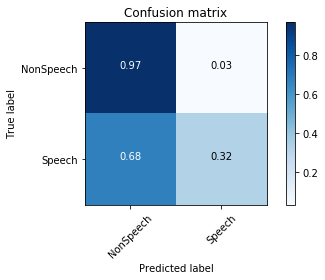

In [25]:

y_predprob = randomRF.predict_proba(test_data)[:,1]
y_pred = randomRF.predict(test_data)

print(randomRF.oob_score_)
print("AUC Score(Test)：{}".format(metrics.roc_auc_score(test_label,y_predprob)))
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(test_label, y_pred, target_names=target_names))
c_metrics = metrics.confusion_matrix(test_label,y_pred)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

In [ ]:
0.9144043968911167
AUC Score(Test)：0.8237170740053263
              precision    recall  f1-score   support

   NonSpeech       0.93      0.97      0.95    776802
      Speech       0.52      0.32      0.40     84336

   micro avg       0.90      0.90      0.90    861138
   macro avg       0.72      0.64      0.67    861138
weighted avg       0.89      0.90      0.89    861138

Normalized confusion matrix
[[0.96752326 0.03247674]
 [0.67799042 0.32200958]]

n_estimators=100===================
0.9312515927052072
AUC Score(Test)：0.8633408911550662
              precision    recall  f1-score   support

   NonSpeech       0.93      0.97      0.95    776802
      Speech       0.55      0.35      0.43     84336

   micro avg       0.91      0.91      0.91    861138
   macro avg       0.74      0.66      0.69    861138
weighted avg       0.89      0.91      0.90    861138

Normalized confusion matrix
[[0.96883891 0.03116109]
 [0.65228372 0.34771628]]

In [12]:
Test_Data_path = os.getcwd()+'\TestSet'
print(Test_Data_path)
Prediction_Evaluation(Test_Data_path,best_RF,Params,example_test_transition_matrix)
pred_Test_prob = best_RF.predict_proba(test_data)[:,1]
pred_Test_class = best_RF.predict(test_data)
viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, example_test_transition_matrix, p_state=0.1, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(test_label, viterbi_result, target_names=target_names))
c_metrics = metrics.confusion_matrix(test_label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=10, verbose=1, warm_start=False)

In [ ]:


Test_Data_path = os.getcwd()+'\TestSet'
print(Test_Data_path)
Prediction_Evaluation(Test_Data_path,best_RF,Params,example_test_transition_matrix)
pred_Test_prob = best_RF.predict_proba(test_data)[:,1]
pred_Test_class = best_RF.predict(test_data)
viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, example_test_transition_matrix, p_state=0.1, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(test_label, viterbi_result, target_names=target_names))
c_metrics = metrics.confusion_matrix(test_label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

In [5]:
best_RF

NameError: name 'best_RF' is not defined

In [22]:
random_grid

{'n_estimators': [5, 28, 52, 76, 100],
 'max_features': ['auto', None],
 'max_depth': [2, 21, 41, 60, 80, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [26]:
for num in np.arange(2.600,50):
    print(np.arange(1,num,10))

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]
[ 1. 11. 21. 31. 41.]


In [60]:
param_grid = {'n_estimators': np.arange(5,300,20),
               'max_features': ['auto','log2'],
               'max_depth': np.arange(1,60,10),
               'min_samples_split': np.arange(2,60,3),
               'min_samples_leaf': np.arange(1,60,3),
               'max_leaf_nodes':np.arange(1,60,3)}
param_grid

{'n_estimators': array([  5,  25,  45,  65,  85, 105, 125, 145, 165, 185, 205, 225, 245,
        265, 285]),
 'max_features': ['auto', 'log2'],
 'max_depth': array([ 1, 11, 21, 31, 41, 51]),
 'min_samples_split': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50,
        53, 56, 59]),
 'min_samples_leaf': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
        52, 55, 58]),
 'max_leaf_nodes': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
        52, 55, 58])}